# Test deployed web application

This notebook pulls some images and tests them against the deployed web application on AKS.

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import requests
from testing_utilities import to_img, plot_predictions, get_auth, read_image_from
from azureml.core.workspace import Workspace
from azureml.core.webservice import AksWebservice
from dotenv import set_key, get_key, find_dotenv

In [2]:
env_path = find_dotenv(raise_error_if_not_found=True)

Get the external url for the web application running on AKS cluster.

In [3]:
ws = Workspace.from_config(auth=get_auth())
print(ws.name, ws.resource_group, ws.location, ws.subscription_id, sep="\n")

Found the config file in: /home/mat/repos/AMLAKSDeploy/Keras_Tensorflow/aml_config/config.json
workspace
deploykerasrg
eastus
edf507a2-6235-46c5-b560-fd463ba2e771


Let's retrieve web service.

In [4]:
aks_service_name = get_key(env_path, 'aks_service_name')
aks_service = AksWebservice(ws, name=aks_service_name)

In [5]:
aks_service.state

'Healthy'

In [6]:
scoring_url = aks_service.scoring_uri
api_key = aks_service.get_keys()[0]

Pull an image of a Lynx to test it with.

In [7]:
IMAGEURL = "https://upload.wikimedia.org/wikipedia/commons/thumb/6/68/Lynx_lynx_poing.jpg/220px-Lynx_lynx_poing.jpg"

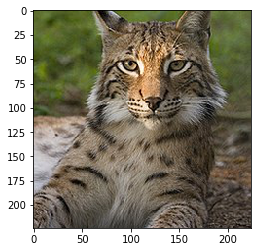

In [8]:
plt.imshow(to_img(IMAGEURL))

In [11]:

headers = {'Authorization':('Bearer '+ api_key)}
img_data = read_image_from(IMAGEURL).read()
r = requests.post(scoring_url, files={'image':img_data}, headers=headers) # Run the request twice since the first time takes a 
                                                              # little longer due to the loading of the model
%time r = requests.post(scoring_url, files={'image':img_data}, headers=headers)
r.json()

CPU times: user 2.01 ms, sys: 235 µs, total: 2.24 ms
Wall time: 188 ms


[{'image': [['n02127052', 'lynx', 0.981648325920105],
   ['n02128385', 'leopard', 0.007744148373603821],
   ['n02123159', 'tiger_cat', 0.0036861379630863667]]},
 'Computed in 98.39 ms']

From the results above we can see that the model correctly classifies this as an Lynx. 

Let's try a few more images.

In [12]:
images = ('https://upload.wikimedia.org/wikipedia/commons/thumb/6/68/Lynx_lynx_poing.jpg/220px-Lynx_lynx_poing.jpg',
          'https://upload.wikimedia.org/wikipedia/commons/3/3a/Roadster_2.5_windmills_trimmed.jpg',
          'http://www.worldshipsociety.org/wp-content/themes/construct/lib/scripts/timthumb/thumb.php?src=http://www.worldshipsociety.org/wp-content/uploads/2013/04/stock-photo-5495905-cruise-ship.jpg&w=570&h=370&zc=1&q=100',
          'http://yourshot.nationalgeographic.com/u/ss/fQYSUbVfts-T7pS2VP2wnKyN8wxywmXtY0-FwsgxpiZv_E9ZfPsNV5B0ER8-bOdruvNfMD5EbP4SznWz4PYn/',
          'https://cdn.arstechnica.net/wp-content/uploads/2012/04/bohol_tarsier_wiki-4f88309-intro.jpg',
          'http://i.telegraph.co.uk/multimedia/archive/03233/BIRDS-ROBIN_3233998b.jpg')

In [13]:
results = [requests.post(scoring_url, files={'image': read_image_from(img).read()}, headers=headers) for img in images]

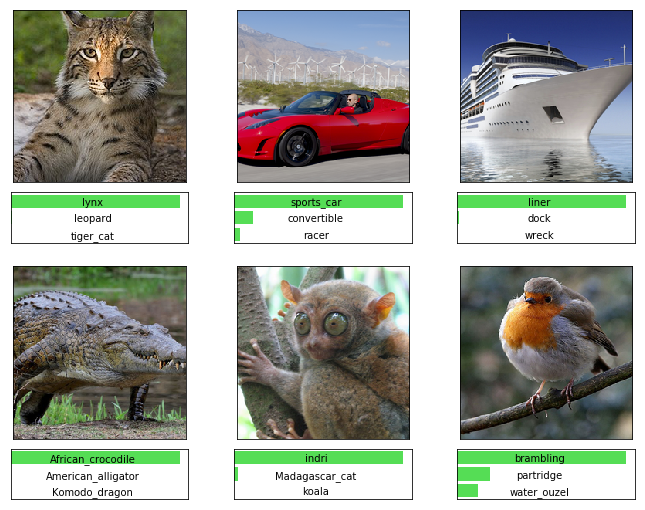

In [14]:
plot_predictions(images, results)

The labels predicted by our model seem to be consistent with the images supplied.

Next let's quickly check what the request response performance is for the deployed model on AKS cluster.

In [19]:
image_data = list(map(lambda img: read_image_from(img).read(), images)) # Retrieve the images and data

In [20]:
timer_results = list()
for img in image_data:
    res=%timeit -r 1 -o -q requests.post(scoring_url, files={'image': img}, headers=headers)
    timer_results.append(res.best)

In [21]:
timer_results

[0.187285644991789,
 1.0542280279914849,
 0.20218201601528563,
 0.20601127669797278,
 0.11124954299884848,
 0.14735912999894935]

In [22]:
print('Average time taken: {0:4.2f} ms'.format(10**3 * np.mean(timer_results)))

Average time taken: 318.05 ms


We have tested that the model works and we can now move on to the [next notebook to get a sense of its throughput](06_SpeedTestWebApp.ipynb).